In [1]:
!python --version

Python 3.11.11


In [5]:
import os 

frame_path = "video/frame"
frames = os.listdir(frame_path)
frames = sorted(frames, key=lambda x: int(x.split('_')[1].split('.')[0]))
print(f"frames: {len(frames)}")

frames: 1501


In [7]:
base_model = "models/yolov7.pt"
tiny_model = "models/yolov7-tiny.pt"
tensor_rt_model = "models/yolov7-tiny.engine"

In [8]:
import sys
import torch.nn as nn
from pathlib import Path
import os

original_utils = sys.modules.get("utils")
notebook_dir = Path(os.getcwd())
y7_dir = notebook_dir / "yolov7"
if y7_dir.exists():
    y7_str = str(y7_dir)
    if y7_str in sys.path:
        sys.path.remove(y7_str)
    sys.path.insert(0, y7_str)
    sys.modules.pop("utils", None)  # avoid shadowing

    from models.yolo import Model
    from models.common import Conv
    from utils.datasets import letterbox
    from utils.general import non_max_suppression, scale_coords
    from torch.serialization import add_safe_globals
    add_safe_globals([Model, nn.Sequential])

_y7_letterbox = letterbox
_y7_nms = non_max_suppression
_y7_scale_coords = scale_coords
conv_cls = Conv

In [9]:
import torch
import cv2 as cv
from tqdm import tqdm
import numpy as np
import time
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv.resize(im, new_unpad, interpolation=cv.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def process_image(image_path, device):
    img_bgr = cv.imread(image_path)
    assert img_bgr is not None, "Failed to load image"

    img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

    img_lb, ratio, dwdh = letterbox(
        img_rgb,
        new_shape=(640, 640),
        auto=False
    )

    img_chw = img_lb.transpose(2, 0, 1)
    img_chw = np.expand_dims(img_chw, axis=0)
    img_chw = np.ascontiguousarray(img_chw, dtype=np.float32)
    input_tensor = torch.from_numpy(img_chw).to(device) / 255.0

    return img_rgb, input_tensor, ratio, dwdh

torch.Size([1, 3, 640, 640])


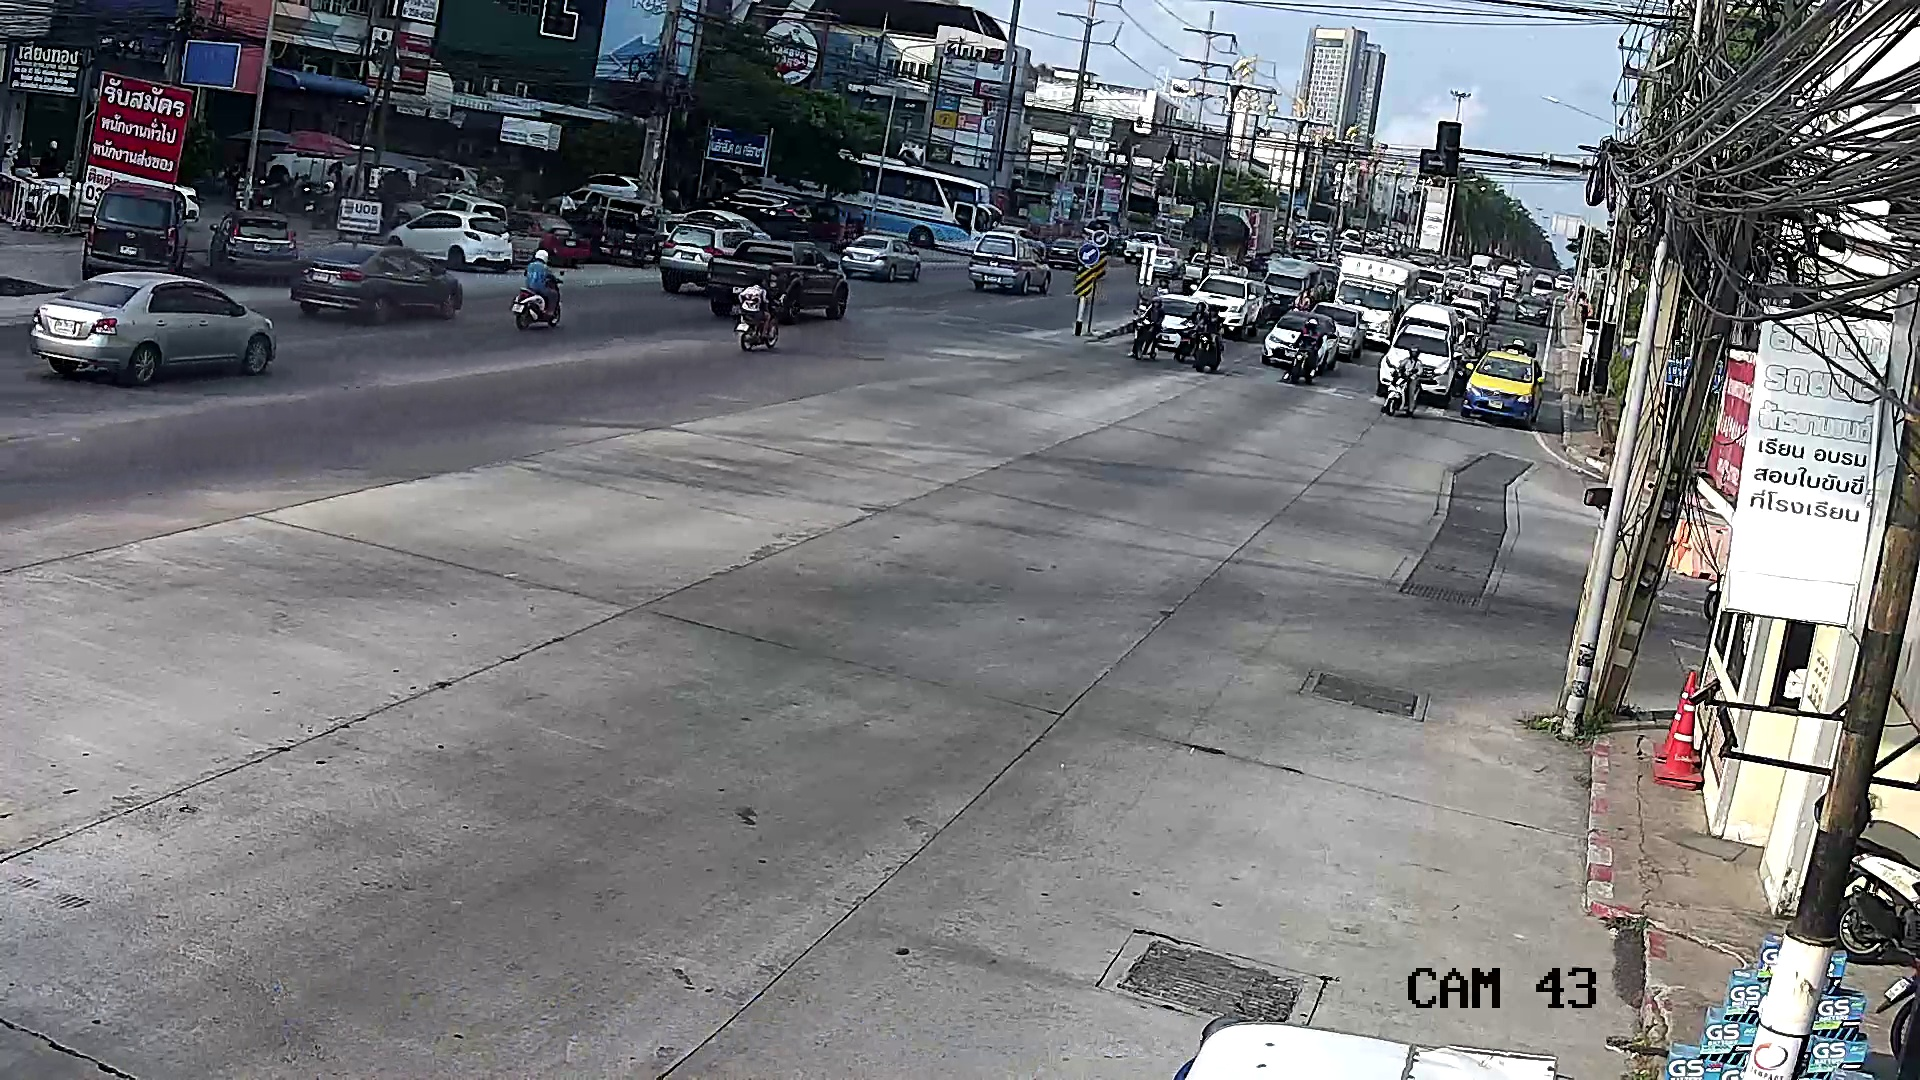

In [11]:
img, input_tensor, _, _ = process_image(os.path.join(frame_path, frames[0]), device)
print(input_tensor.shape)
Image.fromarray(img)

In [12]:
def load_model(model_path, device):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    model = ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval()

    for m in model.modules():
        if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True
        elif type(m) is nn.Upsample:
            m.recompute_scale_factor = None
        elif conv_cls and isinstance(m, conv_cls):
            m._non_persistent_buffers_set = set()

    model.eval()
    model.to(device)

    return model

In [13]:
preprocess_times = []

for frame in tqdm(frames, desc="Processing frames", total=len(frames)):
    t0 = time.perf_counter()
    _, _, _, _ = process_image(os.path.join(frame_path, frame), device)
    t1 = time.perf_counter()
    preprocess_times.append(t1 - t0)

total_time = sum(preprocess_times)
avg_time = total_time / len(preprocess_times)

print(f"Total preprocessing time: {total_time:.4f} s")
print(f"Average preprocessing time per frame: {avg_time:.4f} s")

Processing frames: 100%|██████████| 1501/1501 [00:26<00:00, 57.13it/s]

Total preprocessing time: 26.0723 s
Average preprocessing time per frame: 0.0174 s


In [ ]:
from ultralytics import YOLO

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

preprocess_times = []
inference_times = []
total_times = []

model = YOLO("models/yolo11n.pt", task='detect', verbose=False)

times = []
for frame in tqdm(frames, desc="Processing frames with yolo11n", total=len(frames)):
    t0 = time.perf_counter()
    _, input_tensor, _, _ = process_image(os.path.join(frame_path, frame), device)
    t1 = time.perf_counter()
    preprocess_times.append(t1 - t0)

    with torch.no_grad():
        starter.record()
        pred = model(input_tensor)
        ender.record()

    torch.cuda.synchronize()
    infer_time = starter.elapsed_time(ender) / 1000.0
    inference_times.append(infer_time)

    total_times.append((t1 - t0) + infer_time)

print(f"Total time: {sum(total_times):.4f} s")
print(f"Avg preprocessing time: {sum(preprocess_times)/len(preprocess_times):.4f} s")
print(f"Avg inference time: {sum(inference_times)/len(inference_times):.4f} s")
print(f"Avg total time: {sum(total_times)/len(total_times):.4f} s")

Total time: 58.9825 s

Avg preprocessing time: 0.0179 s

Avg inference time: 0.0214 s

Avg total time: 0.0393 s

In [ ]:
model = YOLO("models/yolo11n.pt", task="detect", verbose=False)

# video writer setup
first_img, _, _, _ = process_image(os.path.join(frame_path, frames[0]), device)
h, w, _ = first_img.shape
fourcc = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter("tracking_yolo11.mp4", fourcc, 25, (w, h))

for frame in tqdm(frames, desc="Saving tracking video", total=len(frames)):
    img_rgb, input_tensor, ratio, dwdh = process_image(os.path.join(frame_path, frame), device)

    with torch.no_grad():
        results = model(input_tensor)[0]

    img_bgr = cv.cvtColor(img_rgb, cv.COLOR_RGB2BGR)

    if results.boxes is not None:
        boxes = results.boxes.xyxy.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)

        dw, dh = dwdh
        dw *= 2
        dh *= 2

        for box, score, cls in zip(boxes, scores, classes):
            x1, y1, x2, y2 = box

            # remove padding
            x1 -= dw / 2
            x2 -= dw / 2
            y1 -= dh / 2
            y2 -= dh / 2

            # scale back to original image
            x1 /= ratio
            x2 /= ratio
            y1 /= ratio
            y2 /= ratio

            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            cv.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{cls}:{score:.2f}"
            cv.putText(
                img_bgr,
                label,
                (x1, y1 - 5),
                cv.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                1,
                cv.LINE_AA,
            )

    out.write(img_bgr)

out.release()
print("Video saved: tracking_output.mp4")

In [19]:
# yolov7.pt

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

preprocess_times = []
inference_times = []
total_times = []

model = load_model(base_model, device)

for frame in tqdm(frames, desc="Processing frames with base model", total=len(frames)):
    t0 = time.perf_counter()
    _, input_tensor, _, _  = process_image(os.path.join(frame_path, frame), device)
    t1 = time.perf_counter()
    preprocess_times.append(t1 - t0)

    with torch.no_grad():
        starter.record()
        pred = model(input_tensor)[0]
        pred = _y7_nms(
            pred,
            conf_thres=0.5,
            iou_thres=0.45,
            classes=None,
            agnostic=False
        )[0]
        ender.record()

    torch.cuda.synchronize()
    infer_time = starter.elapsed_time(ender) / 1000.0
    inference_times.append(infer_time)

    total_times.append((t1 - t0) + infer_time)

print(f"Total time: {sum(total_times):.4f} s")
print(f"Avg preprocessing time: {sum(preprocess_times)/len(preprocess_times):.4f} s")
print(f"Avg inference time: {sum(inference_times)/len(inference_times):.4f} s")
print(f"Avg total time: {sum(total_times)/len(total_times):.4f} s")

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Processing frames with base model: 100%|██████████| 1501/1501 [00:58<00:00, 25.69it/s]

Total time: 57.8584 s
Avg preprocessing time: 0.0148 s
Avg inference time: 0.0237 s
Avg total time: 0.0385 s


In [20]:
# yolov7-tiny.pt

starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

preprocess_times = []
inference_times = []
total_times = []

model = load_model(tiny_model, device)

for frame in tqdm(frames, desc="Processing frames with YOLOv7-tiny"):
    t0 = time.perf_counter()
    _, input_tensor, _, _  = process_image(os.path.join(frame_path, frame), device)
    t1 = time.perf_counter()
    preprocess_times.append(t1 - t0)

    with torch.no_grad():
        starter.record()
        pred = model(input_tensor)[0]
        pred = _y7_nms(
            pred,
            conf_thres=0.5,
            iou_thres=0.45,
            classes=None,
            agnostic=False
        )[0]
        ender.record()

    torch.cuda.synchronize()
    infer_time = starter.elapsed_time(ender) / 1000.0
    inference_times.append(infer_time)

    total_times.append((t1 - t0) + infer_time)

print(f"Total time: {sum(total_times):.4f} s")
print(f"Avg preprocessing time: {sum(preprocess_times)/len(preprocess_times):.4f} s")
print(f"Avg inference time: {sum(inference_times)/len(inference_times):.4f} s")
print(f"Avg total time: {sum(total_times)/len(total_times):.4f} s")

Fusing layers... 


Processing frames with YOLOv7-tiny: 100%|██████████| 1501/1501 [00:38<00:00, 38.95it/s]

Total time: 38.0388 s
Avg preprocessing time: 0.0137 s
Avg inference time: 0.0117 s
Avg total time: 0.0253 s


In [ ]:
import tensorrt as trt
import torch
import numpy as np

INPUT_NAME = "images"
INPUT_SHAPE = (1, 3, 640, 640)

logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, "")

with open(tensor_rt_model, "rb") as f, trt.Runtime(logger) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())

context = engine.create_execution_context()
context.set_input_shape(INPUT_NAME, INPUT_SHAPE)

True

In [29]:
# Allocate buffers

outputs = {}

for i in range(engine.num_io_tensors):
    name = engine.get_tensor_name(i)

    if engine.get_tensor_mode(name) == trt.TensorIOMode.OUTPUT:
        shape = tuple(context.get_tensor_shape(name))
        dtype = trt.nptype(engine.get_tensor_dtype(name))

        outputs[name] = torch.empty(
            shape,
            dtype=torch.from_numpy(np.empty((), dtype=dtype)).dtype,
            device=device
        )

        print(f"Tensor name: {name}", end=" ")
        print(torch.from_numpy(np.empty((), dtype=dtype)).dtype)

        context.set_tensor_address(name, int(outputs[name].data_ptr()))

Tensor name: num_dets torch.int32
Tensor name: det_boxes torch.float32
Tensor name: det_scores torch.float32
Tensor name: det_classes torch.int32


In [31]:
# warm up

for _ in range(10):
    inp = torch.randn(INPUT_SHAPE, device=device)

    context.set_tensor_address(INPUT_NAME, int(inp.data_ptr()))

    stream = torch.cuda.current_stream()
    context.execute_async_v3(stream.cuda_stream)
    stream.synchronize()

In [25]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

preprocess_times = []
inference_times = []
total_times = []

for frame in tqdm(frames, desc="Processing frame with TensorRT model"):
    t0 = time.perf_counter()
    img_rgb, input_tensor, ratio, dwdh = process_image(os.path.join(frame_path, frame), device)
    t1 = time.perf_counter()
    preprocess_times.append(t1 - t0)

    starter.record()
    context.set_tensor_address(INPUT_NAME, int(input_tensor.data_ptr()))
    context.execute_async_v3(torch.cuda.current_stream().cuda_stream)
    ender.record()

    torch.cuda.synchronize()
    infer_time = starter.elapsed_time(ender) / 1000.0
    inference_times.append(infer_time)

    total_times.append((t1 - t0) + infer_time)

print(f"Total time: {sum(total_times):.4f} s")
print(f"Avg preprocessing time: {sum(preprocess_times)/len(preprocess_times):.4f} s")
print(f"Avg inference time: {sum(inference_times)/len(inference_times):.4f} s")
print(f"Avg total time: {sum(total_times)/len(total_times):.4f} s")

Processing frame with TensorRT model: 100%|██████████| 1501/1501 [00:33<00:00, 44.18it/s]

Total time: 33.0688 s
Avg preprocessing time: 0.0154 s
Avg inference time: 0.0066 s
Avg total time: 0.0220 s


In [26]:
h, w, _ = cv.imread(os.path.join(frame_path, frames[0])).shape
video = cv.VideoWriter(
    "tracking_yolov7_trt.mp4",
    cv.VideoWriter_fourcc(*"mp4v"),
    25,
    (w, h),
)

for frame in tqdm(frames, desc="TensorRT YOLOv7 Video"):
    img_bgr, input_tensor, ratio, dwdh = process_image(
        os.path.join(frame_path, frame), device
    )

    context.set_tensor_address(INPUT_NAME, int(input_tensor.data_ptr()))
    context.execute_async_v3(torch.cuda.current_stream().cuda_stream)
    torch.cuda.synchronize()

    num = int(outputs["num_dets"][0].item())
    boxes = outputs["det_boxes"][0][:num].cpu().numpy()
    scores = outputs["det_scores"][0][:num].cpu().numpy()
    classes = outputs["det_classes"][0][:num].cpu().numpy()

    dw, dh = dwdh

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box

        x1 = (x1 - dw) / ratio
        x2 = (x2 - dw) / ratio
        y1 = (y1 - dh) / ratio
        y2 = (y2 - dh) / ratio

        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        cv.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(
            img_bgr,
            f"{cls}:{score:.2f}",
            (x1, y1 - 5),
            cv.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv.LINE_AA,
        )

    video.write(img_bgr)

video.release()

TensorRT YOLOv7 Video: 100%|██████████| 1501/1501 [01:06<00:00, 22.65it/s]


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Baseline",
    "YOLO11",
    "YOLOv7",
    "YOLOv7-Tiny",
    "YOLOv7-Tiny TRT"
]

# Average per-frame times (seconds)
preprocess = [0.0174, 0.0179, 0.0148, 0.0137, 0.0154]
inference  = [0.0,    0.0214, 0.0237, 0.0117, 0.0066]
total      = [0.0174, 0.0393, 0.0385, 0.0253, 0.0220]

x = np.arange(len(models))
width = 0.25

plt.figure()
plt.bar(x - width, preprocess, width, label="Preprocessing")
plt.bar(x,         inference,  width, label="Inference")
plt.bar(x + width, total,      width, label="Total")

plt.xticks(x, models, rotation=20)
plt.ylabel("Average Time per frame (seconds)")
plt.title("Per-frame Time Comparison Across Models (1500 frames)")
plt.legend()
plt.tight_layout()
plt.savefig("comparison.png", dpi=300)